# Improve computation time

In [ ]:
import ggml_ot
import scanpy as sc
import pandas as pd

This tutorial shows how to significantly improve computation speed of GGML, especially for large datasets. We use the Breast cancer dataset from *Kumar et al., 2023* containing 714,331 cells from 126 donors. 

*Note: While these approaches improve the computation speed of GGML, it might significantly impact the performance. Here, we provide guidelines on how to achieve a good trade-off.*

In [2]:
id = "b8b5be07-061b-4390-af0a-f9ced877a068.h5ad"
adata = ggml_ot.data.load_cellxgene(id)
sc.pp.highly_variable_genes(adata,n_top_genes=2000,subset=True)

In [3]:
#Dict to track the performance of different parameters
scores = {}

#For ease of use, we define the reoccuring parameters as a dict
adata_cols = {"patient_col":"donor_id", "label_col":"reported_diseases"}

## Baseline (default)

First, we compute the normal GGML as a baseline.

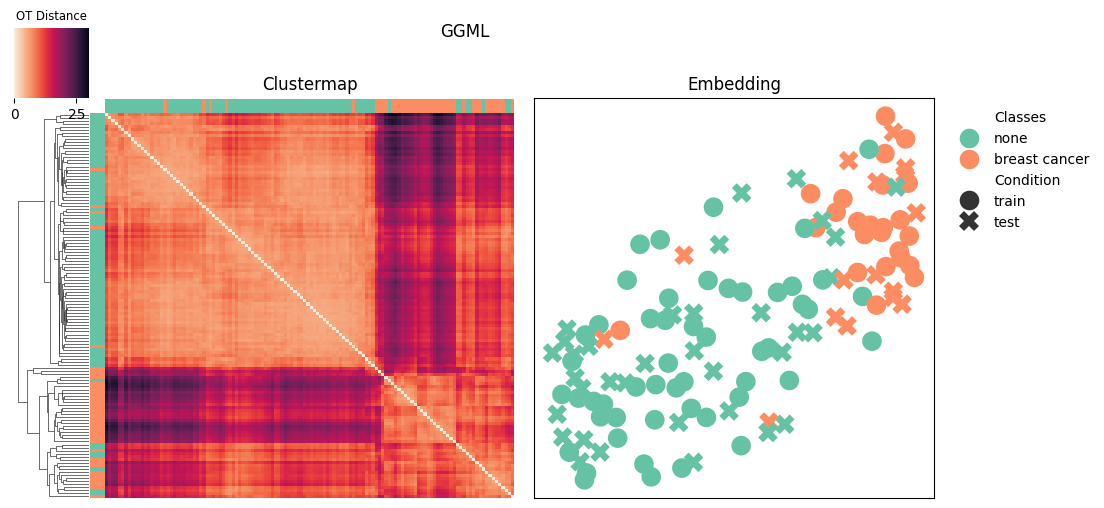

knn_acc,mi,ari,vi,epoch_time
Mean,Mean,Mean,Mean,Mean
0.86,0.49,0.62,0.64,41.37


In [4]:
_, scores["default"] = ggml_ot.from_anndata(
    adata, **adata_cols
).train_test(n_splits = 1)

## Low-dim. embeddings with `use_rep`

So far, we learned the ground metric for the Optimal Transport between the cells in the gene space `.X`. To use a low-dimensional representations (e.g. PCA, Harmony, ...) instead, pass the parameter `use_rep` when loading the dataset. While this improves the computation speed, it might significantly reduce the performance of GGML depending on the task-related information captured by the embedding.

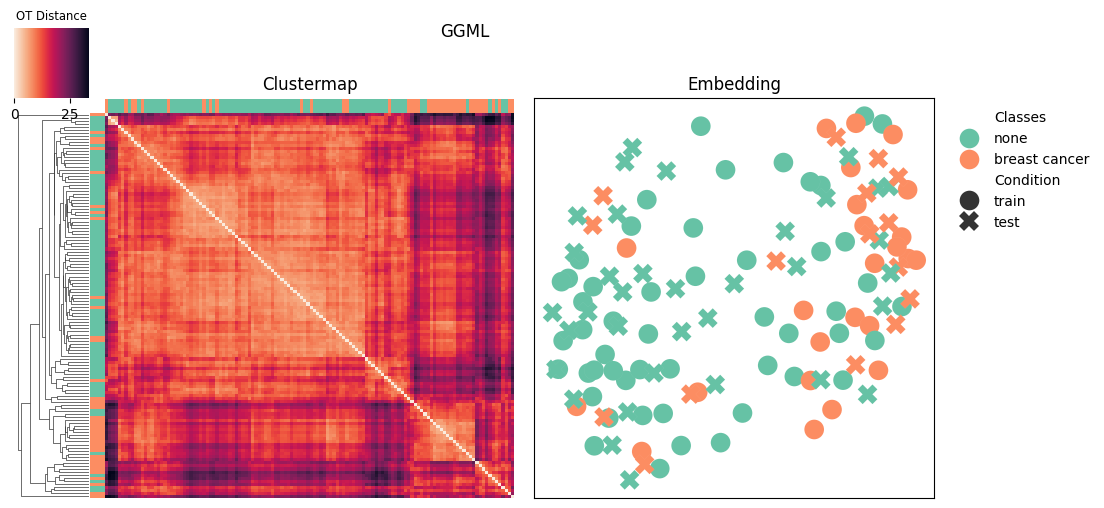

knn_acc,mi,ari,vi,epoch_time
Mean,Mean,Mean,Mean,Mean
0.80,0.03,0.02,0.65,41.86


In [5]:
_, scores["use_rep"] = ggml_ot.from_anndata(
    adata, **adata_cols, use_rep="X_pca"
).train_test(n_splits = 1)

## Cluster cells with `group_by`

Another way to speed-up the computations, is to use Optimal Transport between cell subtypes instead of single cells. As patients have similar cell subtypes, the patient-specific distributions share the corresponding cluster centroids as supports. They only differ in the proportions of these cell subtypes which corresponds to different weights of the supports. 

While this approach improves the speed of the computation, it might significantly reduce the performance of GGML depending on the clustering. In particular, it can not learn any differences within a cluster, so the variance within a cell type is lost. As the existing `.obs["cell_type"]` in the AnnData of this tutorial is potentially too broad (i.e., high variance within clusters) to learn meaningful differences between patients, we compute more granular clusters with Leiden.

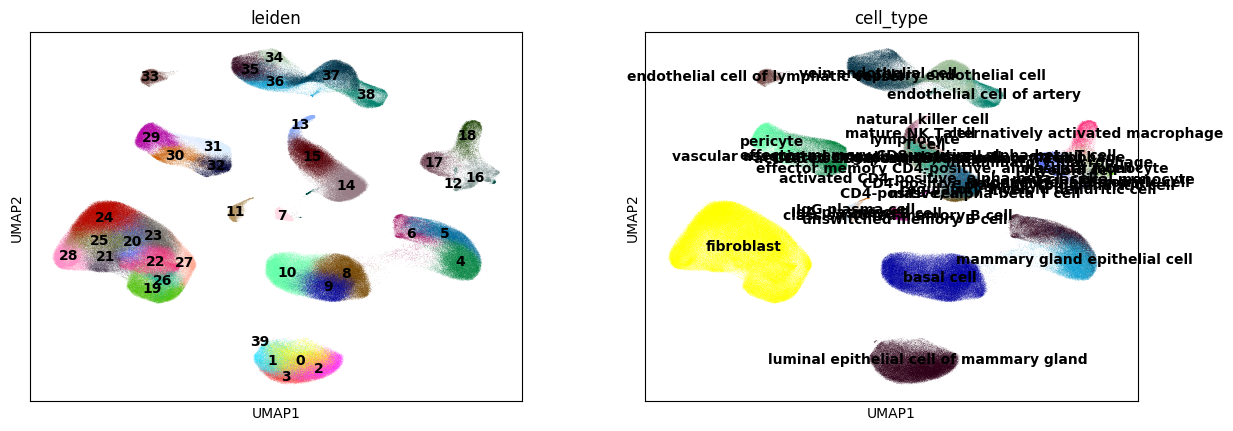

In [6]:
sc.pp.neighbors(adata,use_rep="X_pca") 
sc.tl.leiden(adata, flavor="igraph", resolution=2.0, n_iterations=2)
sc.pl.umap(adata, color=["leiden","cell_type"],legend_loc="on data")

To group the cells according to our computed clusters, we use `group_by="leiden"` when creating our dataset. Now, we can learn the ground metric between the cluster centers instead of single cells which significantly speeds up the training.   

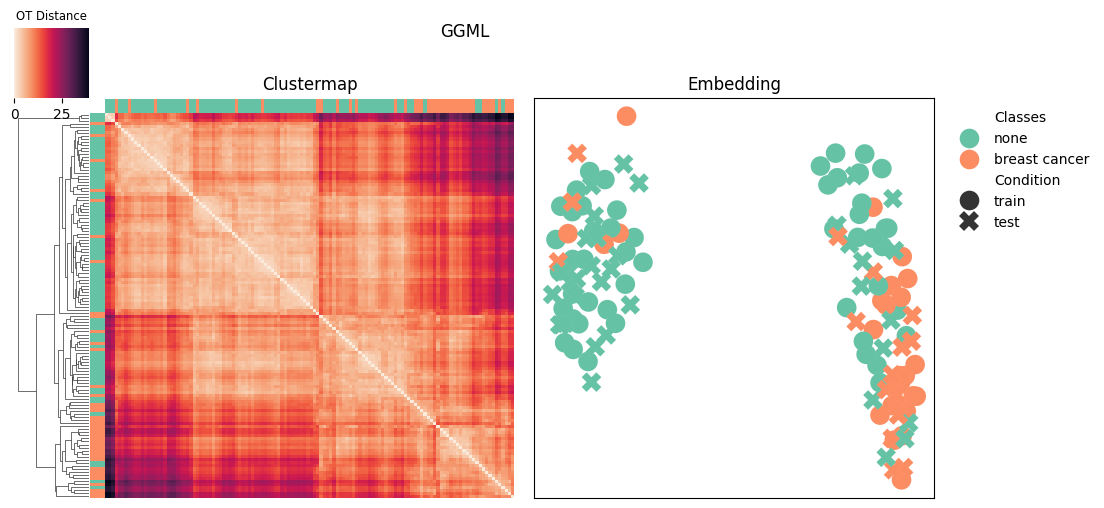

knn_acc,mi,ari,vi,epoch_time
Mean,Mean,Mean,Mean,Mean
0.80,0.03,-0.02,0.72,3.82


In [7]:
_, scores["group_by"] = ggml_ot.from_anndata(
    adata, **adata_cols, group_by="leiden"
).train_test(n_splits = 1)

## Combining `use_rep` and `group_by`

Here, we combine both computational improvements from above, which speeds-up the computation but further reduces the performance.

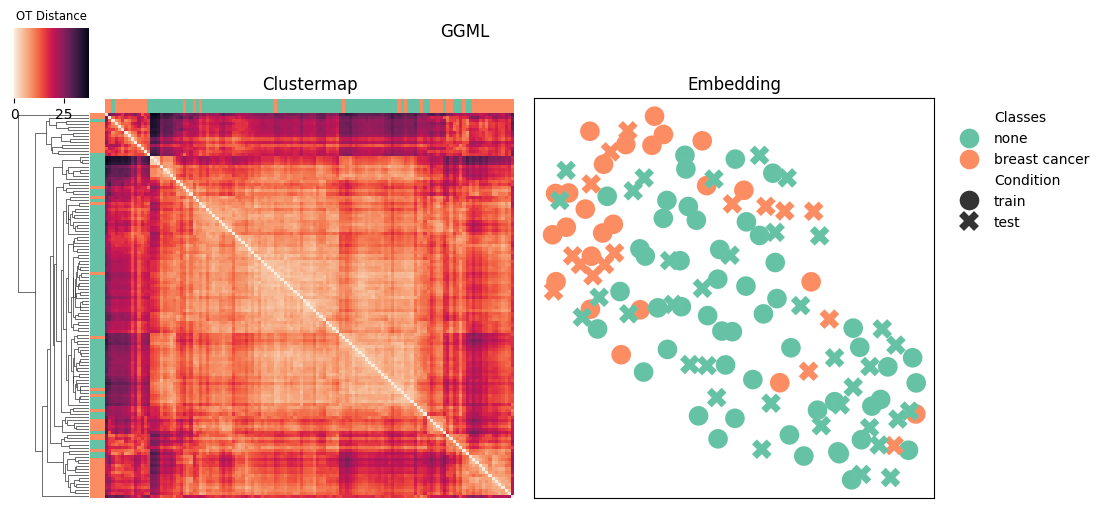

knn_acc,mi,ari,vi,epoch_time
Mean,Mean,Mean,Mean,Mean
0.78,0.03,0.02,0.65,2.33


In [8]:
_, scores["use_rep + group_by"] = ggml_ot.from_anndata(
    adata, **adata_cols, use_rep="X_pca", group_by="leiden"
).train_test(n_splits = 1)

## Reduce number of sampled cells `n_cells`
Depending on the heterogeneity of cells per patient/sample, you might be able to significantly reduce the number of considered cells per patient/sample without reducing performance. Note that if you use the group_by parameter, `n_cells` will have no effect.

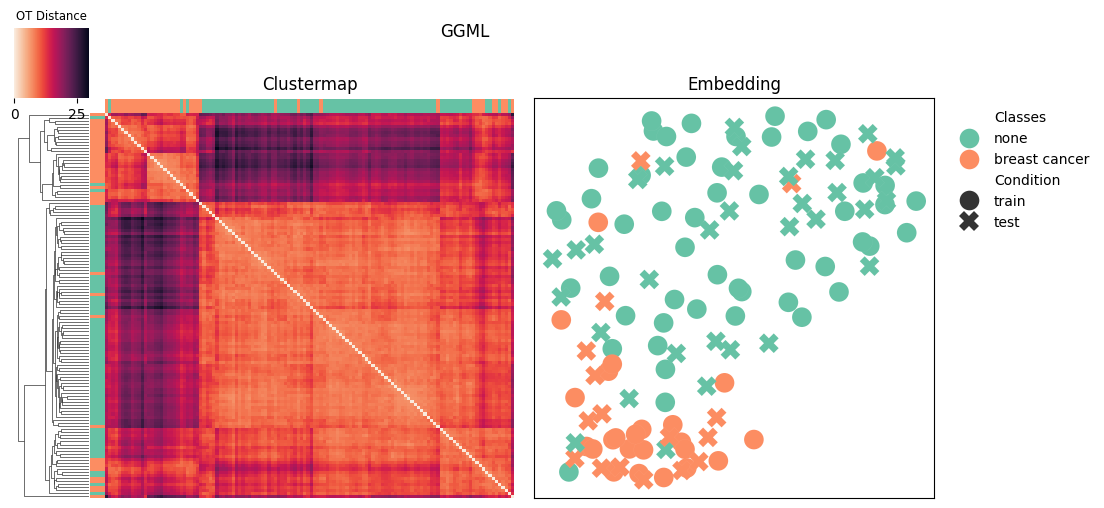

knn_acc,mi,ari,vi,epoch_time
Mean,Mean,Mean,Mean,Mean
0.84,0.40,0.51,0.70,4.82


In [ ]:
_, scores["n_cells"] = ggml_ot.from_anndata(
    adata, **adata_cols, n_cells=100
).train_test(n_splits = 1)

## Reduce number of triplets `n_triplets`

Depending on the heterogeneity within a patient group, reducing the number of relative relationship triplets per patient may not decrease performance. Reducing `n_triplets` should be particularly considered for datasets with many patients or classes (i.e. patient groups), as the number of triplets scales with $n\_triplets \cdot n\_patients \cdot (n\_classes-1)$. 

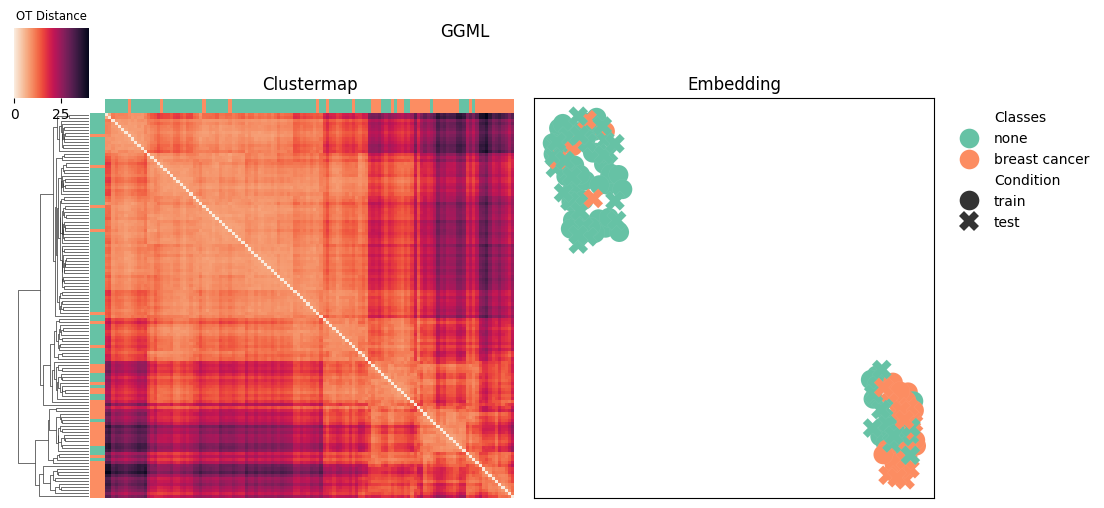

knn_acc,mi,ari,vi,epoch_time
Mean,Mean,Mean,Mean,Mean
0.84,0.32,0.44,0.80,23.47


In [10]:
_, scores["n_triplets"] = ggml_ot.from_anndata(
    adata, **adata_cols, n_triplets=2
).train_test(n_splits = 1)

## Performance comparison of parameters


In [11]:
scores_df = pd.concat(
    [scores[setup] for setup in scores], ignore_index=True
).set_index(
    pd.Index(scores.keys(),name="parameter")
).sort_values(("knn_acc","Mean"),ascending=False)

ggml_ot.pl.table(scores_df, style_performance=True,title="Influence of parameters on performance and computation time")

Metric,knn_acc,mi,ari,vi,epoch_time
Mean±SD,Mean,Mean,Mean,Mean,Mean
parameter,,,,,
default,0.86,0.49,0.62,0.64,41.37
n_triplets,0.84,0.32,0.44,0.80,23.47
n_cells,0.84,0.40,0.51,0.70,4.82
use_rep,0.80,0.03,0.02,0.65,41.86
group_by,0.80,0.03,-0.02,0.72,3.82
use_rep + group_by,0.78,0.03,0.02,0.65,2.33
